In [1]:
# -*- coding: utf-8 -*-

## "Detection of Accounting Anomalies in the Latent Space using Adversarial Autoencoder Neural Networks"


The content of the notebook was jointly developed by Marco Schreyer and Timur Sattarov. Please don't hesitate to contact us in case of any questions via <a href="mailto:marco.schreyer@unisg.ch">marco.schreyer@unisg.ch</a> and <a href="mailto:timur.sattarov@gmail.com">timur.sattarov.timur@gmail.com</a>.

### 1.1 Python Libraries Import

In [2]:
# importing utilities
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display

# importing pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

### 1.2 CUDNN and GPU Verification

To determine if CDNN is available on the server let's execute the cell below to display information about the available CUDNN version:

In [3]:
# print CUDNN backend version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))

[LOG 20190804-02:32:54] The CUDNN backend version: None


Also, let's display information about the potential GPUs running on the server:

In [4]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


If CUDNN and GPU's are available let's still specify if we want to use both:

In [5]:
USE_CUDA = False

### 1.3 Python and PyTorch Verification

Let's execute the cell below to display information about the Python and PyTorch version running on the server:

In [6]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20190804-02:32:54] The Python version: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [7]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20190804-02:32:54] The PyTorch version: 1.0.0


### 1.4 Random Seed Initialization

Finally, let' set the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:

In [8]:
# init deterministic seed
seed_value = 1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

## 2. Financial Fraud Detection Dataset

In this section, we will conduct a descriptive analysis of the financial dataset. Furthermore, we will apply some necessary pre-processing steps to train a deep neural network. The dataset is based on a derivation of the **"Synthetic Financial Dataset For Fraud Detection"** by Lopez-Rojas [6] available via the Kaggle predictive modelling and analytics competitions platform that can be obtained using the following link: https://www.kaggle.com/ntnu-testimon/paysim1.

In [9]:
# load the dataset into the notebook kernel
ori_dataset = pd.read_csv('./data/fraud_dataset_v2.csv')

In [10]:
# inspect the datasets dimensionalities
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20190804-02:32:55] Transactional dataset of 533009 rows and 10 columns loaded


### 2.1 Initial Data and Attribute Assessment

We augmented the dataset and renamed the attributes to appear more similar to a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in local currency,
>- `WRBTR`: the amount in document currency.

Let's also have a closer look into the top 10 rows of the dataset:

In [11]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


You may also have noticed the attribute `label` in the data. We will use this field throughout the lab to evaluate the quality of our trained models. The field describes the true nature of each individual transaction of either being a **regular** transaction (denoted by `regular`) or an **anomaly** (denoted by `global` and `local`). Let's have closer look into the distribution of the regular vs. anomalous transactions in the dataset:

In [12]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Ok, the statistic reveals that, similar to real world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of **100 (0.018%)** anomalous transactions. While the 100 anomalous entries encompass **70 (0.013%)** "global" anomalies and **30 (0.005%)** "local" anomalies as introduced in section 1.2.

In [13]:
# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

### 2.2 Pre-Processing of Categorical Transaction Attributes

From the initial data assessment above we can observe that the majority of attributes recorded in AIS- and ERP-systems correspond to categorical (discrete) attribute values, e.g. the posting date, the general-ledger account, the posting type, the currency. Let's have a more detailed look into the distribution of two dataset attributes, namely (1) the posting key `BSCHL` as well as (2) the general ledger account `HKONT`:

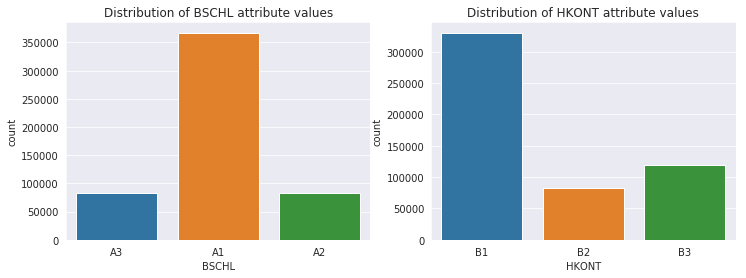

In [14]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of HKONT attribute values');

We pre-process the categorical journal entry attributes to obtain a binary ("one-hot" encoded) representation of each journal entry

In [15]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

Finally, let's inspect the encoding of 10 sample transactions to see if we have been successfull.

In [16]:
# inspect encoded sample transactions
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Pre-Processing of Numerical Transaction Attributes

Let's now inspect the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount DMBTR and the (2) document currency amount WRBTR:

Text(0.5, 1.0, 'Distribution of WRBTR amount values')

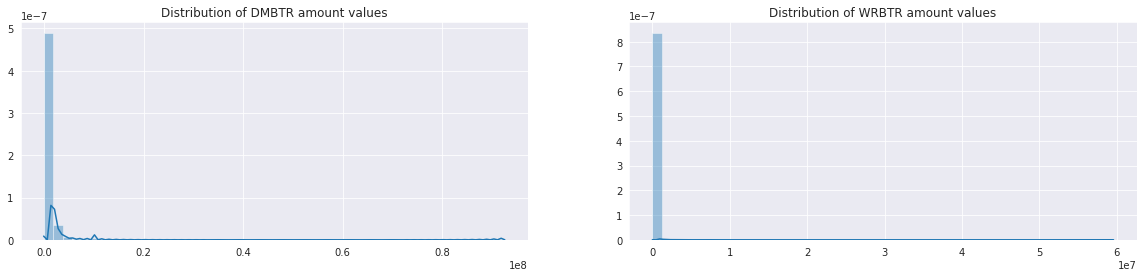

In [17]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

As expected, it can be observed, that for both attributes the distributions of amount values are heavy tailed. In order to approach faster a potential global minimum scaling and normalization of numerical input values is good a practice. Therefore, we first log-scale both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [18]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-4
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

Let's now visualize the log-scaled and min-max normalized distributions of both attributes:

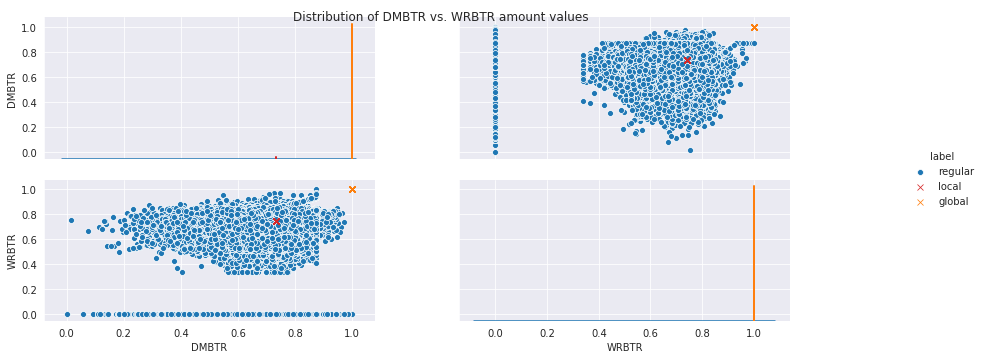

In [19]:
# append 'label' attribute for colour distinction
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label', 
                 palette={'regular': 'C0', 'local': 'C3', 'global': 'C1'}, markers=['o', 'x', 'x'])
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
g.fig.set_size_inches(15, 5)

Ok, as anticipated the numeric attribute values of the "global" anomalies (orange) fall outside the range of the regular amount distributions due to their unusual high amount values. In contrast, the numeric attribute values of the "local" anomalies (red) are much more commingled within the regular transaction amounts.
As DMBTR attribute contains a number of extreme values we might want to visulalize its distribution by omitting those set of extreme values.

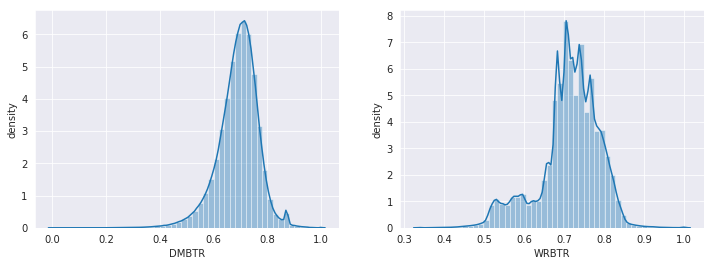

In [20]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

# create train scatter plot
g = sns.distplot(numeric_attr_vis['DMBTR'], kde=True, norm_hist=False, bins=50, label='DMBTR', ax=ax[0])
#g.set_title('Amounts', fontsize=16)

g = sns.distplot(numeric_attr_vis.loc[numeric_attr_vis['WRBTR']!=0.0, 'WRBTR'], kde=True, norm_hist=True, bins=50, 
                 label='WRBTR', ax=ax[1])
#g.set_title('Amounts', fontsize=16)
#ax.legend(loc='upper left', fancybox=True)

# set grid and tight plotting layout
#plt.grid(True)
#plt.tight_layout()
# set plot header
#ax.set_title('Distribution of DMBTR vs. WRBTR amount values')
#ax.set_xlabel('DMBTR and WRBTR')
ax[0].set_ylabel('density')
ax[1].set_ylabel('density');

#g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
#g.fig.set_size_inches(15, 5)

### 2.3 Merge Categorical and Numerical Transaction Attributes

Finally, we merge both pre-processed numerical and categorical attributes into a single dataset that we will use for training our deep autoencoder neural network (explained an implemented in the following section 4.):

In [21]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

Now, let's again have a look at the dimensionality of the dataset after we applied the distinct pre-processing steps to the attributes:

In [22]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

Ok, upon completion of all the pre-processing steps (incl. the exercises) we should end up with an encoded dataset consisting of a total number of 533,009 records (rows) and **618 encoded attributes** (columns). Let's keep the number number of columns in mind since it will define the dimensionality of the input- and output-layer of our deep autoencoder network which we will now implement in the following section.

## 3. Adversarial Autoencoder Neural Network

The Adversarial Autoencoder Neural Network (AAE) architecture, as illustrated in the figure below, extends the concept
of Autoencoder Neural Network (AE) by imposing an arbitrary prior on the AEs latent space using a GAN training setup. This is achieved by training the AAE jointly in two phases (1) a reconstruction phase as well as (2) an adversarial regularization phase.

In the reconstruction phase, the AAEs encoder network $q_{\theta}(z|x)$ is trained to learn an aggregated posterior distribution $q(z)$ of the journal entries $X$ over the latent code vector $Z$. Thereby, the learned posterior distribution corresponds to a compressed representation of the journal entry characteristics. Similarly to AENs, the decoder
network $p_{\theta}(\hat{x}|z)$ of the AAE utilizes the learned latent code vector representations $Z$ to reconstruct the journal entries $\hat{X}$ as faithfully as possible to minimize the AAEs reconstruction error.

In the regularization phase, an adversarial training setup is applied were the encoder network $q_{\theta}(z|x)$ of the AAE functions as the generator network. In addition, a discriminator network $d_{\theta}(z)$ is attached on top of the learned latent code vector $Z$. Similarly to GANs, the discriminator network of the AAE is trained to distinguish samples of an imposed prior distribution $p(z)$ onto $Z$ from the learned aggregated posterior distribution $q(z)$. In contrast, the encoder network is trained to learn a posterior distribution $p(z) ≈ q(z)$ that fools the discriminator network into thinking that the samples drawn from $q(z)$ originate from the imposed prior distribution $p(z)$.

<img align="middle" style="max-width: 830px; height: auto" src="images/autoencoder_2.png">

### 3.1 Adversarial Autoencoder Neural Network Implementation

Implementation of the encoder network:

In [23]:
# define encoder class
class Encoder(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size):

        # call super class constructor
        super(Encoder, self).__init__()

        # init individual layers
        self.map1_L = nn.Linear(input_size, hidden_size[0], bias=True)
        nn.init.xavier_uniform_(self.map1_L.weight)
        nn.init.constant_(self.map1_L.bias, 0.0)
        self.map1_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map2_L = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map2_L.weight)
        nn.init.constant_(self.map2_L.bias, 0.0)
        self.map2_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map3_L = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map3_L.weight)
        nn.init.constant_(self.map3_L.bias, 0.0)
        self.map3_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map4_L = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map4_L.weight)
        nn.init.constant_(self.map4_L.bias, 0.0)
        self.map4_R = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map5_L = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map5_L.weight)
        nn.init.constant_(self.map5_L.bias, 0.0)
        self.map5_R = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    # define forward pass
    def forward(self, x):

        # run forward pass
        x = self.map1_R(self.map1_L(x))
        x = self.map2_R(self.map2_L(x))
        x = self.map3_R(self.map3_L(x))
        x = self.map4_R(self.map4_L(x))
        x = self.map5_R(self.map5_L(x))

        # return result
        return x

Init and push to CUDNN / GPU if avalable:

In [24]:
# init training network classes / architectures
encoder_train = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder_train.cuda()

Validate correct initialization:

In [25]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20190804-02:33:13] encoder architecture:

Encoder(
  (map1_L): Linear(in_features=618, out_features=256, bias=True)
  (map1_R): LeakyReLU(negative_slope=0.4, inplace)
  (map2_L): Linear(in_features=256, out_features=64, bias=True)
  (map2_R): LeakyReLU(negative_slope=0.4, inplace)
  (map3_L): Linear(in_features=64, out_features=16, bias=True)
  (map3_R): LeakyReLU(negative_slope=0.4, inplace)
  (map4_L): Linear(in_features=16, out_features=4, bias=True)
  (map4_R): LeakyReLU(negative_slope=0.4, inplace)
  (map5_L): Linear(in_features=4, out_features=2, bias=True)
  (map5_R): LeakyReLU(negative_slope=0.4, inplace)
)



Implementation of the decoder network:

In [26]:
# define decoder class
class Decoder(nn.Module):

    # define class constructor
    def __init__(self, output_size, hidden_size):

        # call super class constructor
        super(Decoder, self).__init__()

        # init individual layers
        self.map1_L = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map1_L.weight)
        nn.init.constant_(self.map1_L.bias, 0.0)
        self.map1_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map2_L = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map2_L.weight)
        nn.init.constant_(self.map2_L.bias, 0.0)
        self.map2_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map3_L = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map3_L.weight)
        nn.init.constant_(self.map3_L.bias, 0.0)
        self.map3_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map4_L = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map4_L.weight)
        nn.init.constant_(self.map4_L.bias, 0.0)
        self.map4_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        self.map5_L = nn.Linear(hidden_size[4], output_size, bias=True)
        nn.init.xavier_uniform_(self.map5_L.weight)
        nn.init.constant_(self.map5_L.bias, 0.0)
        self.map5_S = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass
        x = self.map1_R(self.map1_L(x))
        x = self.map2_R(self.map2_L(x))
        x = self.map3_R(self.map3_L(x))
        x = self.map4_R(self.map4_L(x))
        x = self.map5_S(self.map5_L(x))

        # return result
        return x

Init and push to CUDNN / GPU if avalable:

In [27]:
# init training network classes / architectures
decoder_train = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder_train.cuda()

Validate correct initialization:

In [28]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20190804-02:33:13] decoder architecture:

Decoder(
  (map1_L): Linear(in_features=2, out_features=4, bias=True)
  (map1_R): LeakyReLU(negative_slope=0.4, inplace)
  (map2_L): Linear(in_features=4, out_features=16, bias=True)
  (map2_R): LeakyReLU(negative_slope=0.4, inplace)
  (map3_L): Linear(in_features=16, out_features=64, bias=True)
  (map3_R): LeakyReLU(negative_slope=0.4, inplace)
  (map4_L): Linear(in_features=64, out_features=256, bias=True)
  (map4_R): LeakyReLU(negative_slope=0.4, inplace)
  (map5_L): Linear(in_features=256, out_features=618, bias=True)
  (map5_S): Sigmoid()
)



Implementation of the discriminator network:

In [29]:
# define discriminator class
class Discriminator(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size, output_size):

        # call super class constructor
        super(Discriminator, self).__init__()

        # init individual layers
        self.map1_L = nn.Linear(input_size, hidden_size[0], bias=True)
        nn.init.xavier_uniform_(self.map1_L.weight)
        nn.init.constant_(self.map1_L.bias, 0.0)
        self.map1_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map2_L = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map2_L.weight)
        nn.init.constant_(self.map2_L.bias, 0.0)
        self.map2_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map3_L = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map3_L.weight)
        nn.init.constant_(self.map3_L.bias, 0.0)
        self.map3_R = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.map4_L = nn.Linear(hidden_size[2], output_size, bias=True)
        nn.init.xavier_uniform_(self.map4_L.weight)
        nn.init.constant_(self.map4_L.bias, 0.0)
        self.map4_S = torch.nn.Sigmoid()


    # define forward pass
    def forward(self, x):

        # run forward pass
        x = self.map1_R(self.map1_L(x))
        x = self.map2_R(self.map2_L(x))
        x = self.map3_R(self.map3_L(x))
        x = self.map4_S(self.map4_L(x))

        # return result
        return x

Init and push to CUDNN / GPU if avalable:

In [30]:
# init training network classes / architectures
discriminator_train = Discriminator(input_size=2, hidden_size=[256, 16, 4, 2], output_size=1)

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    discriminator_train = discriminator_train.cuda()

Validate correct initialization:

In [31]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] discriminator architecture:\n\n{}\n'.format(now, discriminator_train))

[LOG 20190804-02:33:13] discriminator architecture:

Discriminator(
  (map1_L): Linear(in_features=2, out_features=256, bias=True)
  (map1_R): LeakyReLU(negative_slope=0.4, inplace)
  (map2_L): Linear(in_features=256, out_features=16, bias=True)
  (map2_R): LeakyReLU(negative_slope=0.4, inplace)
  (map3_L): Linear(in_features=16, out_features=4, bias=True)
  (map3_R): LeakyReLU(negative_slope=0.4, inplace)
  (map4_L): Linear(in_features=4, out_features=1, bias=True)
  (map4_S): Sigmoid()
)



### 3.2 Adversarial Autoencoder Neural Network Hyperparameter Definition

Define the learning rate of the training:

In [32]:
learning_rate_enc = 1e-3
learning_rate_dec = 1e-3
learning_rate_dis_z = 1e-5

Define AAE reconstruction loss function:

In [33]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical = nn.BCELoss()
reconstruction_criterion_numeric = nn.MSELoss()
reconstruction_criterion_categorical_unreduced = nn.BCELoss(reduction='none')
reconstruction_criterion_numeric_unreduced = nn.MSELoss(reduction='none')

# init the discriminator losses
discriminator_criterion = nn.BCELoss()

Define autoencoder (encoder and decoder net) and discriminator net parameter optimizer:

In [34]:
# define learning rate and optimization strategy
encoder_optimizer = optim.Adam(encoder_train.parameters(), lr=learning_rate_enc)
decoder_optimizer = optim.Adam(decoder_train.parameters(), lr=learning_rate_dec)
discriminator_optimizer = optim.Adam(discriminator_train.parameters(), lr=learning_rate_dis_z)

Specify number of training epochs and mini batch size

In [35]:
# specify training parameters
num_epochs = 2
mini_batch_size = 128

## 4. Training the Adversarial Autoencoder Neural Network Model

In this section, we will train our AAE neural network using the encoded transactional data. More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.
Our architectural setup follows the AAE architecture as shown in the figure above, comprised of three distinct neural networks that are trained in parallel. The encoder network $q_{\theta}$ uses Leaky Rectified Linear
Unit (LReLU) activation functions. Both the decoder network $p_{\theta}$ and the discriminator $d_{\theta}$ network use LReLUs in all layers except the output layers where a Sigmoid activation function is used. 

### 4.1 Creating Latent Space Target Data

The reconstruction loss promotes the AAE to learn a set of nonoverlapping latent journal entry representation. However, this may result in a highly "fractured" latent space in which deviating representations are learned for similar journal entries. The additionally applied adversarial loss prevents the fracturing problem. It forces the learned representations $z$ to reside within the high probability density regions of the imposed prior distribution $p(z)$. To partition the latent space into semantic regions we impose a multi-modal prior, e.g., a mixture of Gaussians. Thereby, the interaction of both
regularising losses forces the AAE to learn groups of semantic similar journal entries located in close spatial proximity to the modes of the imposed prior.

To partition the learned journal entry representations, we sample from a prior distribution $p(z)$ comprised of a mixture of $\tau$ multivariate isotropic Gaussians $\mathcal{N}(\mu,\mathcal{I})$, where $\mu \in \mathcal{R}^{2}$. In the following example we define $\tau=5$.

In [36]:
# sample Guassian distribution(s) of a particular shape
def get_target_distribution(mu, sigma, n, dim=2):

    # determine samples per gaussian
    samples_per_gaussian = int(n / len(mu))

    # determine sample delta
    samples_delta = n - (len(mu) * samples_per_gaussian)

    # iterate over all gaussians
    for i, mean in enumerate(mu):

        # case: first gaussian
        if i == 0:

            # randomly sample from gaussion distribution + samples delta
            z_continous_samples_all = np.random.normal(mean, sigma, size=(samples_per_gaussian + samples_delta, dim))

        # case: non-first gaussian
        else:

            # randomly sample from gaussion distribution + samples delta
            z_continous_samples = np.random.normal(mean, sigma, size=(samples_per_gaussian, dim))

            # stack new samples
            z_continous_samples_all = np.vstack([z_continous_samples_all, z_continous_samples])

    # return sampled data
    return z_continous_samples_all

In [37]:
# determine the radius and theta of the target mixture of gaussians
tau = 5
radius = 0.8
stdv_gauss = 0.01
theta = np.linspace(0, 2 * np.pi, tau, endpoint=False)

# determine x and y coordinates of the target mixture of gaussians
x_centroid = (radius * np.sin(theta) + 1) / 2
y_centroid = (radius * np.cos(theta) + 1) / 2

# determine gaussians mean (centroids) and standard deviation
z_mean = np.vstack([x_centroid, y_centroid]).T

# determine latent space target data
z_target_continous = get_target_distribution(mu=z_mean, sigma=stdv_gauss, n=ori_subset_transformed.shape[0], dim=2)

Figure below shows an exemplary prior consisting of $\tau=5$ Gaussians.

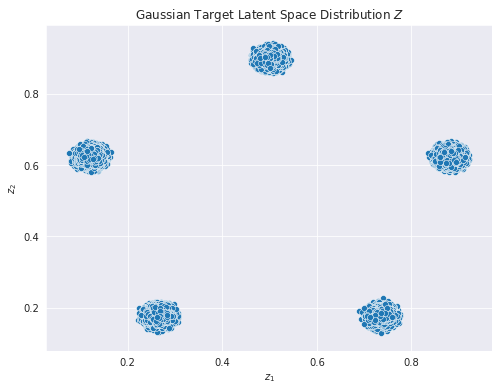

In [38]:
# prepare plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.scatter(z_target_continous[:, 0], z_target_continous[:, 1], c='C0', marker="o", edgecolors='w', linewidth=0.5) 
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

# add plot title
ax.set_title('Gaussian Target Latent Space Distribution $Z$');

### 4.2 Combined Loss Function

In the reconstruction phase, we use a combined loss function $L{\theta}$ to optimize the encoder $q{\theta}$ and decoder net pθ parameters. For each journal entry we calculate the cross-entropy reconstruction error $L^{CE}_{\theta}$ of the categorical attribute value encodings $x^i_{cat}$ and the mean-squared reconstruction error $L^{MSE}_{\theta}$ of the numerical attribute value encodings $x^i_{con}$, formally expressed by:

$\mathcal{L}_{\theta}(x^{i};\hat{x}^{i}) = \gamma \hspace{1mm} \mathcal{L}^{CE}_{\theta}(x^{i}_{cat};\hat{x}^{i}_{cat}) + (1 - \gamma) \hspace{1mm} \mathcal{L}^{MSE}_{\theta}(x^{i}_{con};\hat{x}^{i}_{con})$

were the parameter $\gamma$ balances both losses.

### 4.3 Preparing the Network Training Data

During the training phase, we will fetch the individual mini-batches of the entire population of journal entries. To achieve this, we will use PyTorch's `DataLoader` that provides single- or multi-process iterators over a given dataset to load one mini-batch at a time. By enabling `shuffle=True` the data will be reshuffled at every epoch prior to feeding it to the network. 

In [39]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# note: we set num_workers to zero to retrieve deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

### 4.4 Running the Network Training

In [40]:
# init collection of training losses
reconstruction_losses = []
discriminator_losses_fake = []
discriminator_losses_real = []
discriminator_losses = []
generator_losses = []
mini_batch_print_step = 1000


# initialize training adversarial autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0

    if (torch.backends.cudnn.version() != None) and (use_cuda == True):

        # set all networks / models in GPU mode
        encoder_train.cuda()
        decoder_train.cuda()
        discriminator_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()
    discriminator_train.train()
    
    # start timer
    start_time = datetime.now()

    # iterate over epoch mini batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch to torch variable
        mini_batch_torch = torch.FloatTensor(mini_batch_data)
        
        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== reconstruction phase =====================
        
        # =================== encoder and decoder training
        
        # run autoencoder encoding - decoding
        z_sample = encoder_train(mini_batch_torch)
        mini_batch_reconstruction = decoder_train(z_sample)

        # split input date to numerical and categorical part
        batch_cat = mini_batch_torch[:, :ori_dataset_categ_transformed.shape[1]]
        batch_num = mini_batch_torch[:, ori_dataset_categ_transformed.shape[1]:]
        # split reconstruction to numerical and categorical part
        rec_batch_cat = mini_batch_reconstruction[:, :ori_dataset_categ_transformed.shape[1]]
        rec_batch_num = mini_batch_reconstruction[:, ori_dataset_categ_transformed.shape[1]:]

        # backward pass + gradients update
        rec_error_cat = reconstruction_criterion_categorical(input=rec_batch_cat, target=batch_cat)  # one-hot attr error
        rec_error_num = reconstruction_criterion_numeric(input=rec_batch_num, target=batch_num)  # numeric attr error

        # combine both reconstruction errors
        reconstruction_loss = rec_error_cat + rec_error_num
        
        # run backward pass - determine gradients
        reconstruction_loss.backward()
        
        # collect reconstruction loss
        # reconstruction_losses.extend([reconstruction_loss.item()])

        # update network parameter - decoder and encoder
        decoder_optimizer.step()
        encoder_optimizer.step()

        if mini_batch_count % mini_batch_print_step == 0:

            print('------------------------------------------')
            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[PT LOG TRAIN {}] epoch: [{:04}/{:04}], batch: {:04}, reconstruction loss: {:.4f}'
                  .format(now, epoch + 1, num_epochs, mini_batch_count, reconstruction_loss.item()))
            print('-----------------')

        # =================== regularization phase =====================

        # =================== discriminator training

        # set discriminator in evaluation mode
        discriminator_train.eval()

        # generate target latent space data
        z_target_batch = get_target_distribution(mu=z_mean, sigma=stdv_gauss, n=mini_batch_data.shape[0], dim=2)

        # convert to torch tensor
        z_target_batch = torch.FloatTensor(z_target_batch)

        if (torch.backends.cudnn.version() != None) and (use_cuda == True):
            z_target_batch = z_target_batch.cuda()

        # determine mini batch sample generated by the encoder -> fake gaussian sample
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of both samples
        d_real_gauss = discriminator_train(z_target_batch) # real sampled gaussian 
        d_fake_gauss = discriminator_train(z_fake_gauss) # fake created gaussian

        # determine discriminator classification target variables
        d_real_gauss_target = torch.FloatTensor(torch.ones(d_real_gauss.shape)) # real -> 1
        d_fake_gauss_target = torch.FloatTensor(torch.zeros(d_fake_gauss.shape)) # fake -> 0

        if (torch.backends.cudnn.version() != None) and (use_cuda == True):

            d_real_gauss_target = d_real_gauss_target.cuda()
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine individual discrimination losses
        discriminator_loss_real = discriminator_criterion(target=d_real_gauss_target, input=d_real_gauss) # real loss
        discriminator_loss_fake = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss) # fake loss

        # collection discrimination losses
        discriminator_losses_real.extend([discriminator_loss_real.item()])
        discriminator_losses_fake.extend([discriminator_loss_fake.item()])
        
        # add real loss and fake loss
        discriminator_loss = discriminator_loss_fake + discriminator_loss_real

        # run backward through the discriminator network
        discriminator_loss.backward()

        # update network the discriminator network parameters
        discriminator_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        if mini_batch_count % mini_batch_print_step == 0:

            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[PT LOG TRAIN {}] epoch: [{:04}/{:04}], batch: {:04}, discriminator loss: {:.4f} [real_{:.4f}/fake_{:.4f}]'
                  .format(now, epoch + 1, num_epochs, mini_batch_count, 
                          discriminator_loss.item(), discriminator_loss_real.item(), discriminator_loss_fake.item()))
            print('-----------------')

        # =================== generator training

        # set encoder / generator in training mode
        encoder_train.train()
        
        # reset the encoder / generator networks gradients
        encoder_train.zero_grad()

        # determine fake gaussian sample generated by the encoder / generator
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of fake gaussian sample
        d_fake_gauss = discriminator_train(z_fake_gauss)

        # determine discriminator classification target variables
        d_fake_gauss_target = torch.FloatTensor(torch.ones(d_fake_gauss.shape)) # fake -> 1

        if (torch.backends.cudnn.version() != None) and (use_cuda == True):

            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine discrimination loss of fake gaussian sample
        generator_loss = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss)
        
        # collect generation losses
        # generator_losses.extend([generator_loss.item()])

        # run backward pass - determine gradients
        generator_loss.backward()

        # update network paramaters - encoder / generatorc
        encoder_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        if mini_batch_count % mini_batch_print_step == 0:

            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[PT LOG TRAIN {}] epoch: [{:04}/{:04}], batch: {:04}, generator loss: {:.4f}'
                  .format(now, epoch + 1, num_epochs, mini_batch_count, generator_loss.item()))
            print('------------------------------------------')

    # =================== validation on the entire dataset ============================            

    encoder_eval = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])
    decoder_eval = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])
    discriminator_eval = Discriminator(input_size=2, hidden_size=[256, 16, 4, 2], output_size=1)

    # convert encoded transactional data to torch Variable
    enc_transactions = torch.FloatTensor(torch_dataset)

    # set networks in evaluation mode (don't apply dropout)
    encoder_eval.eval()
    decoder_eval.eval()
    discriminator_eval.eval()

    # determine latent space representation of all transactions
    z_enc_transactions = encoder_eval(enc_transactions)

    # reconstruct input samples
    reconstruction = decoder_eval(z_enc_transactions)

    # split input transactions into numeric and categorical parts
    input_cat_all = enc_transactions[:, :ori_dataset_categ_transformed.shape[1]]
    input_num_all = enc_transactions[:, ori_dataset_categ_transformed.shape[1]:]
    # split reconstruction into numeric and categorical parts
    rec_cat_all = reconstruction[:, :ori_dataset_categ_transformed.shape[1]]
    rec_num_all = reconstruction[:, ori_dataset_categ_transformed.shape[1]:]

    # compute rec error
    rec_error_cat_all = reconstruction_criterion_categorical(input=rec_cat_all, target=input_cat_all)
    rec_error_num_all = reconstruction_criterion_numeric(input=rec_num_all, target=input_num_all)

    # combine categorical and numerical errors
    rec_error_all = rec_error_cat_all + rec_error_num_all          
    reconstruction_losses.extend([rec_error_all.item()])
    
    # evaluate discriminator error
    z_fake = discriminator_eval(z_enc_transactions)
    
    # determine discriminator classification target variables
    z_fake_target = torch.FloatTensor(torch.ones(z_fake.shape)) # fake -> 1

    # determine discrimination loss of fake gaussian sample
    discriminator_loss = discriminator_criterion(target=z_fake_target, input=z_fake)

    # collect generation losses
    discriminator_losses.extend([discriminator_loss.item()])

    # print reconstuction results
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[PT LOG VALIDATION {}] epoch: [{:04}/{:04}], reconstruction loss: {:.4f}'
          .format(now, epoch + 1, num_epochs, rec_error_all.item()))
    print('[PT LOG VALIDATION {}] epoch: [{:04}/{:04}], discriminator loss: {:.4f}'
          .format(now, epoch + 1, num_epochs, discriminator_loss.item()))
    print('------------------------------------------')
            
    # =================== save model snapshots to disk ============================
    
    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))
    
    # save trained discriminator model file to disk
    decoder_model_name = "{}_ep_{}_discriminator_model.pth".format(now, (epoch+1))
    torch.save(discriminator_train.state_dict(), os.path.join("./models", decoder_model_name))

------------------------------------------
[PT LOG TRAIN 20190804-02:33:42] epoch: [0001/0002], batch: 1000, reconstruction loss: 0.0314
-----------------
[PT LOG TRAIN 20190804-02:33:42] epoch: [0001/0002], batch: 1000, discriminator loss: 1.3890 [real_0.7010/fake_0.6880]
-----------------
[PT LOG TRAIN 20190804-02:33:42] epoch: [0001/0002], batch: 1000, generator loss: 0.6983
------------------------------------------
------------------------------------------
[PT LOG TRAIN 20190804-02:34:05] epoch: [0001/0002], batch: 2000, reconstruction loss: 0.0266
-----------------
[PT LOG TRAIN 20190804-02:34:05] epoch: [0001/0002], batch: 2000, discriminator loss: 1.3876 [real_0.6967/fake_0.6909]
-----------------
[PT LOG TRAIN 20190804-02:34:05] epoch: [0001/0002], batch: 2000, generator loss: 0.6954
------------------------------------------
------------------------------------------
[PT LOG TRAIN 20190804-02:34:29] epoch: [0001/0002], batch: 3000, reconstruction loss: 0.0267
---------------

Let's now evaluate if the loss function is indeed going down with progressing training of the model. Therefore, let's visualize the magnitudes of the losses obtained per training epoch:

Text(0.5, 1.0, 'AENN training performance')

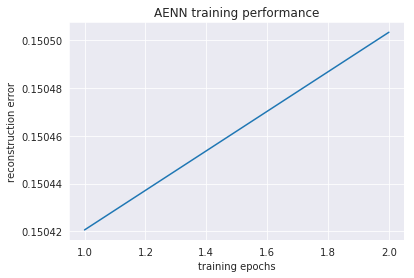

In [48]:
# plot the training progress
plt.plot(range(1, len(reconstruction_losses)+1), reconstruction_losses)
plt.xlabel('training epochs')
#plt.xlim([0, len(reconstruction_losses)])
plt.ylabel('reconstruction error')
#plt.ylim([0.0, 1.0])
plt.title('AENN training performance');

Text(0.5, 1.0, 'AENN training performance')

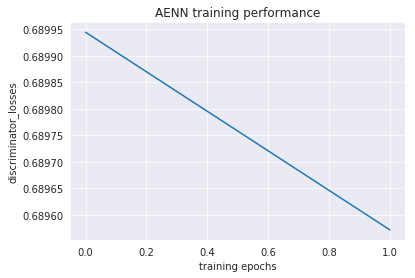

In [50]:
# plot the training progress
plt.plot(range(0, len(discriminator_losses)), discriminator_losses)
plt.xlabel('training epochs')
#plt.xlim([0, len(discriminator_losses)])
plt.ylabel('discriminator_losses')
#plt.ylim([0.0, 1.0])
plt.title('AENN training performance');

How does the reconstruction loss change as we progress in training our model? After 5 epochs, we can observe that our reconstruction loss already went down significantly and starts to converge nicely. This indicates that our network did a pretty good job in learning the structure and attributes of the journal entries.

But, from the plot we also observe that the model could probably be trained a couple more epochs as the trend of the reconstruction error still decreases for the last few epochs. In order to save time, we will continue the lab using a pre-trained model already trained by 20 epochs.

## 5. Evaluating the Autoencoder Neural Network (AENN) Model

In order, to detect interpretable accounting anomalies in real-world ERP datasets we propose a novel anomaly score utilizing the introduced AAE architecture. The score builds on the regularisation applied throughout the AAE training process, namely the reconstruction error loss and the adversarial loss, described in the following.

In [43]:
# restore pretrained model checkpoint
encoder_model_name = "20190801-16_43_14_ep_20_encoder_model.pth"
decoder_model_name = "20190801-16_43_14_ep_20_decoder_model.pth"

# init training network classes / architectures
encoder_eval = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])
decoder_eval = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# load trained models
encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))

### 5.1 Reconstruction Error (RE)

Journal entries that exhibit anomalous attribute value co-occurrences (local anomalies) tend to result in an increased reconstruction error. This is caused by the compression capability of the AAE architecture. Anomalous and therefore unique attribute co-occurrences exhibit an increased probability of getting lost in the encoders "lossy" compression. As a result, their low dimensional representation will overlap with regular entries in the latent space and are not reconstructed correctly by the decoder. Formally, we obtain the reconstruction error $E$ of each entry $x^i$ and its reconstruction $\hat{x}^i$ as the squared-difference denoted by $E_{\theta^*}^{\tau}(x^{i};\hat{x}^{i}) = \frac{1}{k} \sum_{j=1}^{k}{(x^{i}_{j} - \hat{x}^{i}_{j})}^2$ under optimal model parameters $\theta^*$. Finally, we calculate the normalized reconstruction error $RE$ as expressed by:

\begin{equation}
RE_{\theta^*}^{\tau}(x^{i};\hat{x}^{i}) = \frac{E_{\theta^*}^{\tau}(x^i;\hat{x}^{i}) - E_{\theta^*, min}^{\tau}}{E_{\theta^*, max}^{\tau} - E_{\theta^*, min}^{\tau}},
\end{equation}

where $E_{min}$ and $E_{max}$ denotes the min- and max-values of the obtained reconstruction errors given by $E_{\theta^*}$ and closest mode $\tau$.


In [60]:
# convert encoded transactional data to torch Variable
enc_transactions = torch.FloatTensor(torch_dataset)

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# determine latent space representation of all transactions
z_enc_transactions = encoder_eval(enc_transactions)

# reconstruct input samples
reconstruction = decoder_eval(z_enc_transactions)

# split input transactions into numeric and categorical parts
input_cat_all = enc_transactions[:, :ori_dataset_categ_transformed.shape[1]]
input_num_all = enc_transactions[:, ori_dataset_categ_transformed.shape[1]:]
# split reconstruction into numeric and categorical parts
rec_cat_all = reconstruction[:, :ori_dataset_categ_transformed.shape[1]]
rec_num_all = reconstruction[:, ori_dataset_categ_transformed.shape[1]:]

# compute rec error
rec_error_cat_all = reconstruction_criterion_categorical_unreduced(input=rec_cat_all, target=input_cat_all).mean(dim=1)
rec_error_num_all = reconstruction_criterion_numeric_unreduced(input=rec_num_all, target=input_num_all).mean(dim=1)

# combine categorical and numerical errors
rec_error_all = rec_error_cat_all + rec_error_num_all

### 5.2 Mode Divergence

Journal entries that exhibit anomalous attribute values (global anomalies) result in an increased divergence from the imposed multi-modal prior, e.g., as in this work the divergence to the modes of an imposed mixture of multivariate isotropic Gaussians $\mathcal{N}(\mu,\mathcal{I})$, where $\mu \in \mathcal{R}^m$ defines the $\tau$ modes of the distinct Gaussians denoted by $\mu =\{\mu^1 \ldots \mu^\tau \}$. Throughout the AAE training, the entries will be "pushed" towards the high probability density regions of the prior by the regularization. In order to be able to discriminate between the imposed prior and the learned aggregated posterior the AAE aims to keep the majority of the entries within the high-density regions (modes) of the prior. In contrast, representations that correspond to rare or anomalous journal entries will tend to differ from the imposed modes and be placed in the priors low-density regions. We use this characteristic and obtain an entry's $x^{i}$ mode divergence $D$ as the Euclidean distance of the entry's learned representation $z^i$ to its closest mode $\mu^\tau$. Formally, we derive the mode divergence as denoted by $D_{\theta^*}^{\tau}(z^{i};\mu) = \min\limits_{\tau} \lVert z^i-\mu^\tau \rVert^2 $ under optimal model parameters $\theta^*$. Finally, we calculate the normalized mode divergence $MD$ as expressed by:

\begin{equation}
MD_{\theta^*}^{\tau}(x^{i}) = \frac{D_{\theta^*}^{\tau}(z^i;\mu) - D_{\theta^*, min}^{\tau}}{D_{\theta^*, max}^{\tau} - D_{\theta^*, min}^{\tau}},
\end{equation}

where $D_{min}$ and $D_{max}$ denotes the min- and max-values of the obtained mode divergences given by $D_{\theta^*}$ and closest mode $\tau$.

In [45]:
# define the Mode Divergence function according to the formula above
def compute_MD(z, means):
    def compute_euclid_dist(x, y):
        return np.sqrt(np.sum((x - y) ** 2, axis=1))

    distances = np.apply_along_axis(func1d=compute_euclid_dist, axis=1, arr=z, y=means)
    return np.min(distances, axis=1), np.argmin(distances, axis=1)

In [61]:
# convert latent space representation reconstruction errors to numpy
z_enc = z_enc_transactions.cpu().data.numpy()
rec_error_all = rec_error_all.cpu().data.numpy()

# collect distances to the cluster means in the latent space
cluster_distances, cluster_ids = compute_MD(z=z_enc, means=z_mean)

### scale MD and RE across each cluster modes
# prepare empty arrays of the same shape and dtype
rec_error_all_scaled = np.asarray(rec_error_all)
cluster_distances_scaled = np.asarray(cluster_distances)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
    # identify the group of transactions assigned to a cluster
    mask = cluster_ids == cluster_id
    # scale the samples to the range [0,1] across the samples within this cluster
    rec_error_all_scaled[mask] = (rec_error_all[mask] - rec_error_all[mask].min()) / (rec_error_all[mask].ptp())
    cluster_distances_scaled[mask] = (cluster_distances[mask] - cluster_distances[mask].min()) / (cluster_distances[mask].ptp())    
    

### 5.3 Anomaly Score

Quantifying both characteristics for a given journal entry, we can reasonably conclude (1) if the entry is anomalous and (2) if it was created by a "regular" business activity. To detect global and local accounting anomalies in real-world audit scenarios we propose to score each journal entry $x^i$ by its normalized reconstruction error $RE$ regularized and normalized mode divergence $MD$ given by:

\begin{equation}
AS^{\tau}(x^{i};\hat{x}^{i}) = \alpha \times RE_{\theta^*}^{\tau}(x^{i};\hat{x}^{i}) + (1-\alpha) \times MD_{\theta^*}^{\tau}(x^{i}),
\end{equation} 

for each individual journal entry $x^{i}$ and optimal model parameters $\theta^*$ and closest mode $\tau$. We introduce $\alpha$ as a factor to balance both characteristics. 


In [64]:
# compute Anomaly Score
alpha = 0.8
anomaly_score = alpha * rec_error_all_scaled + (1.0 - alpha) * cluster_distances_scaled

### 5.4 Visualization of the Anomaly Score of Individual Transactions

Once we have collected individual reconstruction errors let's visualize them accordingly:

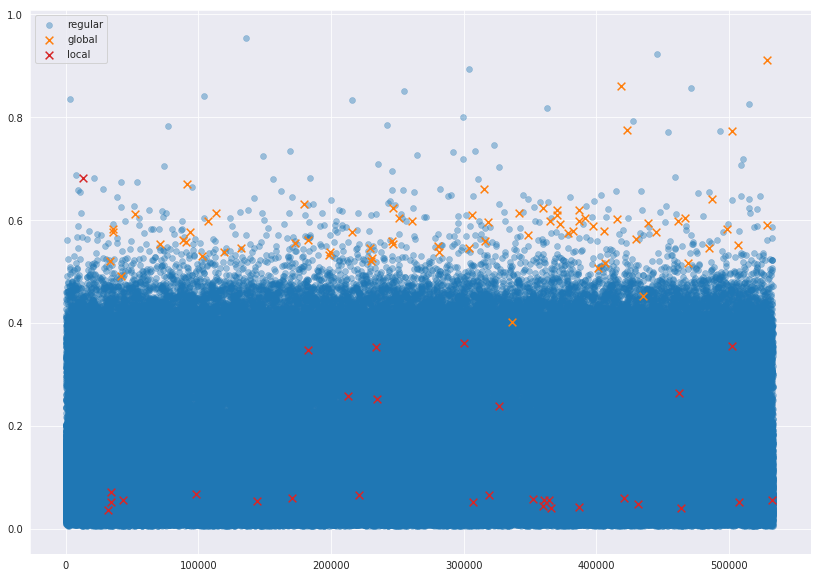

In [67]:
# prepare plot
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(anomaly_score)), anomaly_score))

# obtain regular transactions as well as global and local anomalies
regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', marker="o", label='regular', alpha=0.4, edgecolors='C0', linewidth=0.5) # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="x", label='global', s=60) # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C3', marker="x", label='local', s=60) # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best');

### 6.4 Inspection of the Latent Space

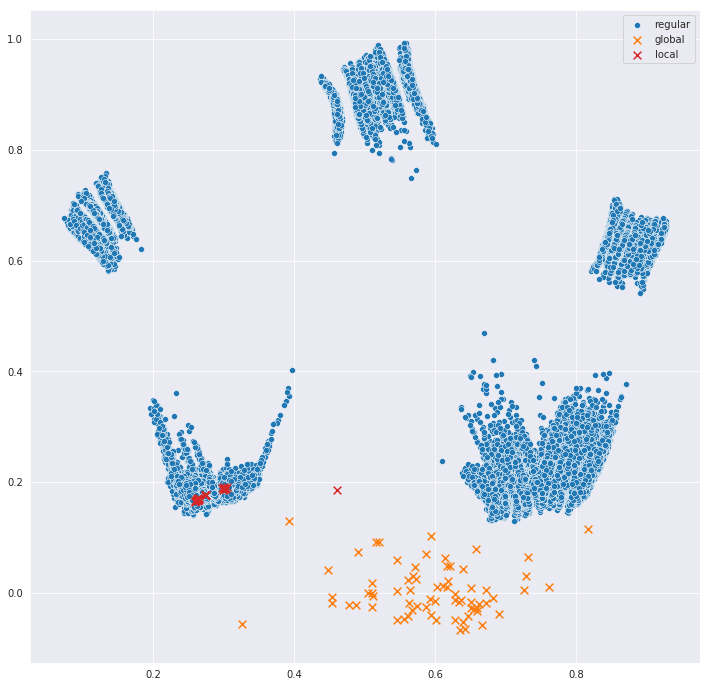

In [56]:
# prepare plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# obtain regular transactions as well as global and local anomalies
regular_data = z_enc[label == 'regular']
global_outliers = z_enc[label == 'global']
local_outliers = z_enc[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', marker="o", label='regular', edgecolors='w', linewidth=0.5) # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="x", label='global', edgecolors='w', s=60) # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C3', marker="x", label='local', edgecolors='w', s=60) # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best');

The visualization reveals that the pre-trained model is able to reconstruct the majority of regular journal entries, while failing to do so, for the anomalous ones. As a result, the model reconstruction error can be used to distinguish both "global" anomalies (orange) and "local" anomalies (green) from the regular journal entries (blue).

To further investigate our observation and confirm the initial assumption, let's have a closer look into the journal entries exhibiting a "high" binary cross-entropy reconstruction error >= 0.1. We assume that these journal entries correspond to the "global" anomalies of the original dataset:

In [ ]:
# append labels to original dataset
ori_dataset['label'] = label

# inspect transactions exhibiting a reconstruction error >= 0.2
ori_dataset[anomaly_score >= 0.6]

Let's now also have a closer look into the journal entries exhibiting a "medium" binary cross-entropy reconstruction error >= 0.02 and < 0.1. We assume that these journal entries mostly correspond to the "local" anomalies of the original dataset:

In [ ]:
# inspect transactions exhibiting a anomaly_score < 0.1 and >= 0.05
ori_dataset[(anomaly_score >= 0.5) & (anomaly_score < 0.6)]

In [ ]:
!jupyter nbconvert --to script KDD_2019.ipynb

## References

Major elements of the lab content are inspired by the publication "Detection of Anomalies in Large Scale Accounting Data using Deep Autoencoder Networks", of M. Schreyer, T. Sattarov, D. S. Borth, A. Dengel, and B. Reimer, 2017 (arXiv preprint available under: https://arxiv.org/abs/1709.05254).

[1] ACFE, "Report to the Nations on Occupational Fraud and Abuse", The 2016 Global Fraud Study, Association of Certified Fraud Examiners (ACFE), 2016.

[2] J. T. Wells, "Corporate Fraud Handbook: Prevention and Detection", John Wiley & Sons, 2017.

[3] PwC, "Pulling Fraud Out of the Shadows", The Global Economic Crime and Fraud Survey 2018, PricewaterhouseCoopers LLP, 2018.

[4] S. Markovitch, P. Willmott, "Accelerating the digitization of business processes", McKinsey & Company (2014) 1–5.

[5] SAP, SAP Global Corporate Affairs, Corporate Factsheet 2017, 2017.

[6] E. A. Lopez-Rojas , A. Elmir, and S. Axelsson, "PaySim: A financial mobile money simulator for fraud detection", In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus, 2016.

[7] G. E. Hinton, and R. R. Salakhutdinov, "Reducing the dimensionality of data with neural networks", science 313, no. 5786: 504-507, 2006.

[8] N. Srivastava, G. E. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, "Dropout: A simple way to prevent neural networks from overfitting", The Journal of Machine Learning Research, 15(1), 1929-1958, 2014.

[9] X. Glorot and Y. Bengio, "Understanding the difficulty of training deep feedforward neural networks", Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS), 9:249–256, 2010.

[10] B. Xu, N. Wang, T. Chen, and M. Li, "Empirical Evaluation of Rectified Activations in Convolution Network", ICML Deep Learning Workshop, pages 1–5, 2015.

[11] D. P. Kingma and J. Ba, "Adam: A method for stochastic optimization", International Conference on Learning Representations (ICLR). 2015.

[12] G. E. Hinton, N. Srivastava, A. Krizhevsky, I. Sutskever, R. R. Salakhutdinov. "Improving neural networks by preventing co-adaptation of feature detectors", Technical Report, 2012.

[13] D. P. Kingma, M. Welling. "Auto-encoding variational bayes", arXiv preprint arXiv:1312.6114, 2013.

[14] Makhzani, A., Shlens, J., Jaitly, N., Goodfellow, I., & Frey, B., "Adversarial autoencoders", arXiv preprint arXiv:1511.05644, 2015.
